**SOW-MKI49: Neural Information Processing Systems**  
*Weeks 4 and 5: Assignment (100 points + 20 bonus points)  
Author: Luca and Umut

In [1]:
# Group number: 14
# Veerle Schepers s1023102
# Angeliki-Ilektra Karaiskou, s1029746
# Lei Xiaoxuan, s1025681
# Parsia Basimfar : s1022274

In [1]:
from chainer import cuda, datasets, serializers,optimizers
from chainer.dataset import DatasetMixin, concat_examples
from chainer.iterators import MultithreadIterator
from chainer.functions.loss.vae import gaussian_kl_divergence
import chainer
import chainer.functions as F
import chainer.links as L
#import cupy
import numpy as np
import tqdm
import IPython
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%matplotlib inline

import matplotlib
import os
import pickle
import random

This is the decoder class. It transforms latents (features) to observables (images). It corresponds to p(x | z) in the context of variational inference (and the slides), where x is observables and y is latents.

Task: (10 points)

- Implement the decoder class for a variational autoencoder. Note that the decoder should output the Gaussian distribution parameters (mean and variance per pixel) of images rather than images themselves.

In [3]:
class Decoder(chainer.ChainList):
    def __init__(self): # <= you might want to pass some architecture parameters (e.g., #i/o units, etc.) here
        # input  = z        = latents
        
        # output = mean_x   = observables mean
        #        & ln_var_x = observables variance
        
        
        super(Decoder, self).__init__(
            # pass your decoder layers here
            # p(z,x) = D_p(x | g_p(z))p(z)
            
            #lin_dec_1 = 
            L.Linear(100,300),
            #lin_dec_2 =
            L.Linear(300,500),
            #lin_dec_mu     =
            L.Linear(500, 784),
            #lin_dec_ln_var = 
            L.Linear(500, 784)

        )

    def __call__(self, x):
        h1_dec = self[0](x)
        h1_dec = F.relu(h1_dec)
        h2_dec = self[1](h1_dec)
        h2_dec = F.relu(h2_dec)
        
        h_dec_mu = self[2](h2_dec)
        h_dec_mu = F.sigmoid(h_dec_mu)
        h_dec_ln_var = self[3](h2_dec)
        h_dec_ln_var = F.sigmoid(h_dec_ln_var)
        
        
        return h_dec_mu, h_dec_ln_var

This is the encoder class. It transforms observables (images) to latents (features). It corresponds to q(z | x) in the context of variational inference (and the slides), where z is latents and x is observables.

Task: (10 points)

- Implement the encoder class for a variational autoencoder. Note that the encoder should output the Gaussian distribution parameters (mean and variance per feature) of features rather than features themselves.

In [4]:
class Encoder(chainer.ChainList): #Q(z|X)
    def __init__(self): 
        # <= you might want to pass some architecture parameters (e.g., #i/o units, etc.) here
        # input = image = x
        # output = mean_z and variance_z
        
        # MNIST images have a dimension of 28 * 28 pixels with one color channel
        # 28*28*1 = 784
        
        
        super(Encoder, self).__init__(
            # pass your encoder layers here
            # q(z,x) = D_q((z | h_q(x))k(x))
            
            # hidden layers
            # 3 Layered ReLu 784 - 500 - 300 - 100
            
            #l0in_enc_1 = 
            L.Linear(784,500),
            #lin_enc_2 = 
            L.Linear(500,300),
            #lin_enc_mu     = 
            L.Linear(300,100),
            #lin_enc_ln_var =
            L.Linear(300,100)        

        )

    def __call__(self, x):    
        h1_enc = self[0](x)
        h1_enc = F.relu(h1_enc)
        h2_enc = self[1](h1_enc)
        h2_enc = F.relu(h2_enc)        
        h_enc_mu = self[2](h2_enc)
        h_enc_ln_var = self[3](h2_enc)

        return h_enc_mu, h_enc_ln_var

This is the loss class. The loss of encoder and decoder of a variational autoencoder is the evidence lower bound as follows:

$L = D_{KL}(q(z | x), p(z)) -  E_{z\sim q}[log p(x | z)]$

The first term above is the KL divergence between the approximate posterior (q) and the prior (p), which can be interpreted as a form of regularization. You can assume that the prior is unit Gaussian. It can be implemented with the F.gaussian_kl_divergence function in Chainer.

The second term above is the Gaussian negative log likelihood. This is the term that fits the data, which is very similar to the usual loss functions that you use in deep learning. It can be implemented with the F.gaussian_nll function in Chainer.

Task: 

- Implement the loss class. (10 points)

As input, it gets the following arguments:

mean_y => mean of the encoded features (output of the encoder)  
ln_var_y => log variance of the encoded features (output of the encoder)  
x => input images (mini batch)  
mean_x => mean of the decoded images (output of the decoder)  
ln_var_x => mean of the decoded images (output of the decoder)  

As output, it gives the loss.

- Explain why we use log variance instead of variance. (5 points)

In [5]:
class Loss(object):
    def __call__(self, mean_z, ln_var_z, x, mean_x, ln_var_x):
        generation_loss = F.gaussian_nll(x, mean_x, ln_var_x)
        latent_loss = F.gaussian_kl_divergence(mean_z, ln_var_z)
        loss = generation_loss + latent_loss
        return loss 

In [7]:
# Explain why we use log variance instead of variance. (5 points)

# Since the log variance is a function that monotonically increases by its argument,
# maximazing of the log variance is equal to maximizing the function itself.
# When using the log variance we can use a sum instead of a product which makes it easier to use it in computations.
# thus, it simplifies the mathimatical analysis.

# Also, taking the product of a great amount of small probabilities can casue underflow in the numerical precision.
# This is not the case when the sum of the logarithmic probabilities is used.
# Thus, it leads to a more precise answer.

This is the model class. It combines the encoder and the decoder.

Task: (20 points)

- Implement the reparameterziation trick for sampling latents. (10 points)
- Explain why we need to use this trick. (10 points)

In [6]:
class Model(chainer.Chain):
    def __init__(self, decoder, encoder):
        super(Model, self).__init__()

        with self.init_scope():
            self.decoder = decoder
            self.encoder = encoder

    def __call__(self, x):
        ln_var_z, mean_z = self.encoder(x)
        
        # Sample latents (z) from the Gaussian with parameters ln_var_z, mean_z by using the reparameterization trick
        # z = mean_z + ln_var_z * epsilon
        # epsilon is a fixed stocastic node, standard gaussian (mean = 0, sd = 1)
        
        # Define eps
        #eps = cupy.random.normal(loc=0.0, scale=1.0) # or 
        eps = np.random.normal(0,1) 
        # calculate sigma_z from ln_var_z
        sigma_z = F.exp(ln_var_z / 2)
        # calculate sampled latent vector z
        z = mean_z + sigma_z * eps
        ln_var_x, mean_x = self.decoder(z)

        return mean_z, ln_var_z, mean_x, ln_var_x

In [9]:
# Explain why we need to use this trick. (10 points)

# We need to use the reparameterization trick because we cannot run backpropagation without it due to the sampled latent vector.
# This is impossible since the sampled latent vector is a stocastic node which blocks the back propagation.
# The reparameterization trick adds another node next to the mean and the vaiance, namely epsilon.
# Epsilon is gonna be standard gaussian, so it has mean = 0 and sd = 1.
# We now can sammple from epsilon, multiply this with sigma, and add mu.
# So instead of having a full stocactis node z that blocks backpropagation
# We split it up into a part where we can do backpropagation
# and another part that is still stocastic (epsilon)
# but we don't want to train epsilon since it is fixed, this is not a problem.

This is a helper class to use the Mnist dataset.

In [7]:
class Mnist(DatasetMixin):
    def __init__(self):
        self.dataset = datasets.get_mnist(False)[0 if chainer.config.train else 1]

    def __len__(self):
        return len(self.dataset)

    def get_example(self, i):
        return self.dataset[i]
    
    # The MNIST database is a dataset of handwritten digits. 
    # It has 60,000 training samples, and 10,000 test samples. 
    # Each image is represented by 28x28 pixels, 
    # each containing a value 0 - 255 with its grayscale value.

Task: (50 points)

- Train the above defined variational autoencoder on the Mnist dataset. You can refer to the earlier assignments to implement your training loop. (25 points)

- How good are the samples? Randomy sample some digits and visualize them. (10 points)

- How good are the reconstructions? Draw an Mnist like digit, encode it, decode it and visualize the digits. How different is the reconstruction from the original. (10 points)

- Repeat the last task but by drawing something other than a digit (e.g., a face). How accuracte is the reconstructions? Explain the results. (5 points)

In [8]:
class VAE(object):
    def __init__(self): # Here I will add more things
        self.log = {('test', 'accuracy'): (), ('test', 'loss'): (), ('training', 'accuracy'): (),
                    ('training', 'loss'): ()}
        self.encoder=Encoder()
        self.decoder=Decoder()
        self.model = Model(self.decoder,self.encoder)
        self.optimizer = optimizers.Adam(0.0002, 0.5)
        self.optimizer.setup(self.model)
        self.loss =Loss()

    def __call__(self, x):
        mean_z, ln_var_z, mean_x, ln_var_x = self.model(x)
        
        return mean_z, ln_var_z, mean_x, ln_var_x

    @classmethod
    def load(cls, directory):
        self = cls()
        self.log = np.load('{}/log.npy'.format(directory))
        # Load model
        serializers.load_npz('{}/model.npz'.format(directory), self.model)
        serializers.load_npz('{}/optimizer.npz'.format(directory), self.optimizer)
        
        return self

    def save(self, directory):
        np.save('{}/log.npy'.format(directory), self.log)
        # Save model
        serializers.save_npz('{}/model.npz'.format(directory), self.model)
        serializers.save_npz('{}/optimizer.npz'.format(directory), self.optimizer)

    def test(self, x):
        with chainer.using_config('train', False):
            # Forward prop
            # Forward prop     
            mean_z, ln_var_z, mean_x, ln_var_x = self.model(x)
            loss = self.loss(mean_z, ln_var_z, x, mean_x, ln_var_x)
            self.log['test', 'loss'] += (float(loss.data),)
            
            return mean_z, ln_var_z, mean_x, ln_var_x 

    def train(self,x):
        # same as in test
        mean_z, ln_var_z, mean_x, ln_var_x = self.model(x)
        loss = self.loss(mean_z, ln_var_z, x, mean_x, ln_var_x)   
        # cleargrads() -- Clears all gradient arrays.
            # This method should be called before the backward computation at every iteration of the optimization.
        # backprop() -- Backpropagation works by using a loss function to calculate how far the network was from the target output.
        # optimizer.update() -- Updates the parameters.
        
        # use self to get the model and optimizer from the init
        
        self.model.cleargrads()
        loss.backward()
        self.optimizer.update()

        self.log['training', 'loss'] += (float(loss.data),)

---------------------------------------

INITIALIZATION
-------------------------------

-------------------------------------------------------------------------

In [9]:
from chainer import iterators, dataset

Dataset = Mnist()
device = 0
loss_fn = Loss()
batch_size = 64
#model_directory = 'Model'
model_directory = 'C:\\Users\\Αngeliki-Ilektra\\NeuralInformationProcessingSystems\\3rdAs\\modelDirectory'
model = Model(Decoder(), Encoder()).to_cpu()
#vae = VAE()
training_set = Dataset[:int(0.8*55000)]
validation_set = Dataset[int(0.8*55000):55000]
test_set = Dataset[55000:len(Dataset)]

loss_history = {'training': [], 'validation': []}


training_iterator = iterators.SerialIterator(training_set, batch_size, False, True)
print(enumerate(training_iterator))
validation_iterator = iterators.SerialIterator(validation_set, batch_size, False, False)
test_iterator = iterators.SerialIterator(test_set, batch_size, False, False)

#vae.model.to_cpu()
epochs=2
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

TRAINING
-------------------------

In [16]:
epochs = 50
for i in range(epochs):
    loss_history['training'].append(0)
    training_iterator.reset()
    validation_iterator.reset()
    for j, batch in enumerate(training_iterator):
        with chainer.using_config('train', True):
            x = chainer.Variable(dataset.concat_examples(batch, device))
            mean_z, ln_var_z, mean_x, ln_var_x = model(x)
            
            # (1) start
            loss = loss_fn(mean_z, ln_var_z, x, mean_x, ln_var_x)
            model.cleargrads()
            loss.backward()

            optimizer.update()
        
        loss_history['training'][-1] += float(loss.data)
    loss_history['training'][-1] /= j + 1
    
    loss_history['validation'].append(0)


    for j1, batch1 in enumerate(validation_iterator):
        with chainer.using_config('train', False):
            x1 = chainer.Variable(dataset.concat_examples(batch1, device))
            mean_z1, ln_var_z1, mean_x1, ln_var_x1 = model(x1)

            loss = loss_fn(mean_z1, ln_var_z1,x1, mean_x1, ln_var_x1)
            model.cleargrads()
            loss.backward()

            optimizer.update()
        loss_history['validation'][-1] += float(loss.data)
    loss_history['validation'][-1] /= j1 + 1

    print("iteration i = ")
    print(i)
    print("is ended and we are going to the next one")
    print("-------------------------------------------")
    print('epoch: {:3d} / {:03d}, training loss: {:.4f} , validation loss: {:.4f}.'.format(i + 1, epochs, loss_history ['training'][i], loss_history['validation'][i]))
    np.savez('{:s}/loss_history_{:03d}.npz'.format(model_directory, epochs), loss_history)
    serializers.save_npz('group14_FinalModel_50epochs.model.zip', model)

    serializers.save_npz('{:s}/optimizer_{:03d}.npz'.format(model_directory, epochs), optimizer)


iteration i = 
0
is ended and we are going to the next one
-------------------------------------------
epoch:   1 / 050, training loss: 48083.0586 , validation loss: 47178.4802.
iteration i = 
1
is ended and we are going to the next one
-------------------------------------------
epoch:   2 / 050, training loss: 47006.5895 , validation loss: 46906.6103.
iteration i = 
2
is ended and we are going to the next one
-------------------------------------------
epoch:   3 / 050, training loss: 46767.9022 , validation loss: 46764.9023.
iteration i = 
3
is ended and we are going to the next one
-------------------------------------------
epoch:   4 / 050, training loss: 46682.2168 , validation loss: 46657.6344.
iteration i = 
4
is ended and we are going to the next one
-------------------------------------------
epoch:   5 / 050, training loss: 46594.6632 , validation loss: 46590.3595.
iteration i = 
5
is ended and we are going to the next one
-------------------------------------------
epoch: 

TESTING
------------------------------

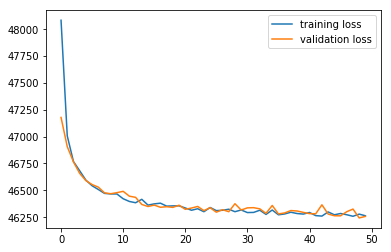

In [24]:
train = plt.plot(np.arange(50), loss_history['training'], label = 'training loss')
validate = plt.plot( np.arange(50), loss_history['validation'], label = 'validation loss')
plt.legend(['training loss', 'validation loss'])

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


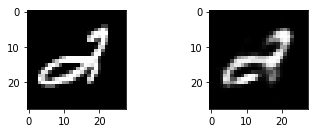

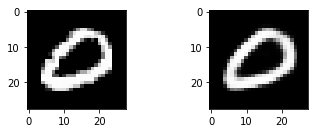

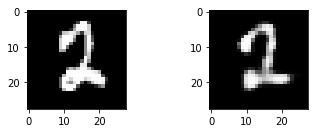

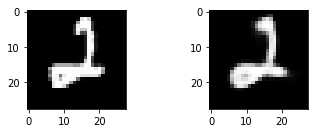

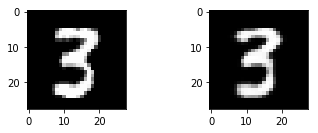

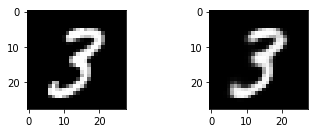

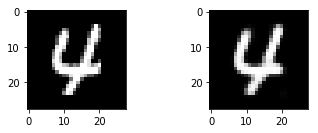

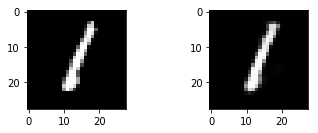

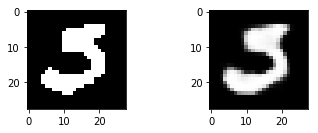

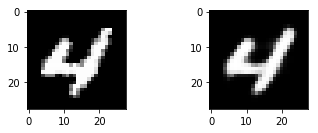

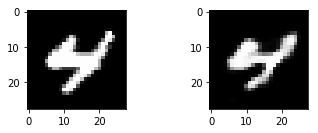

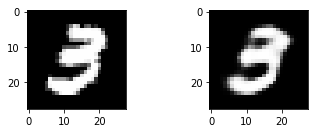

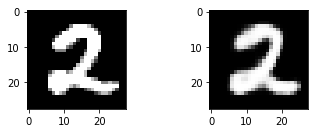

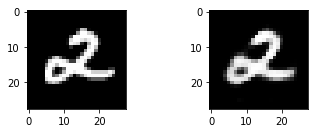

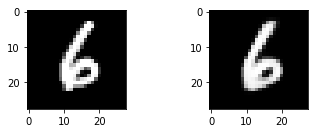

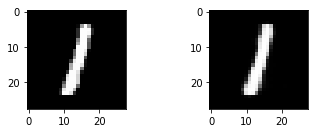

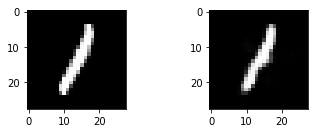

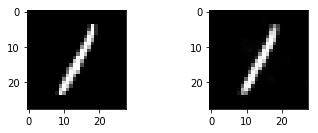

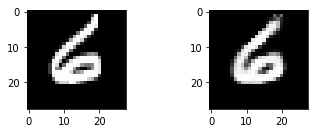

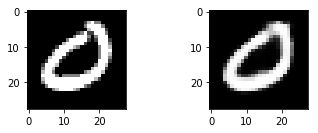

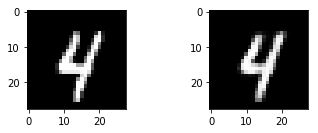

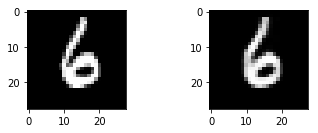

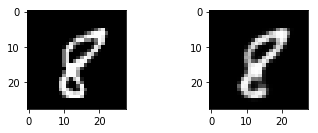

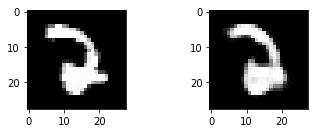

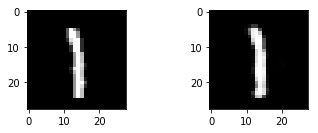

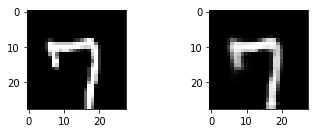

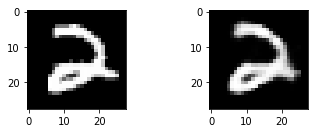

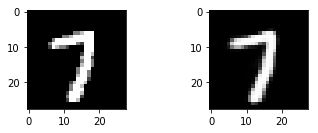

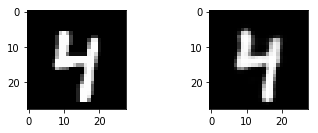

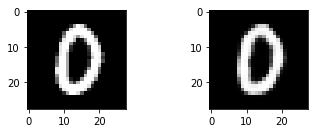

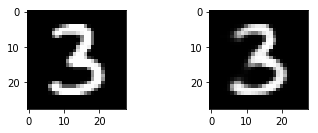

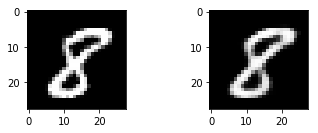

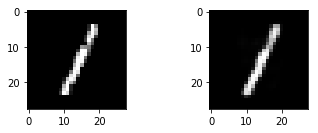

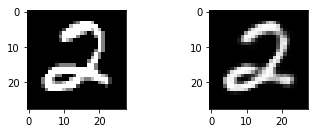

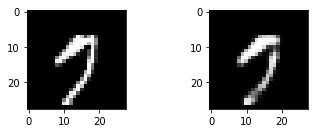

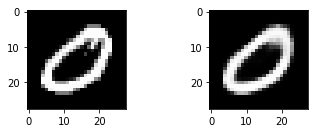

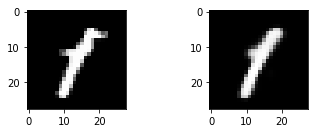

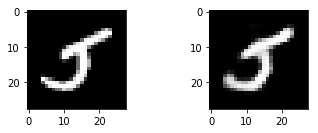

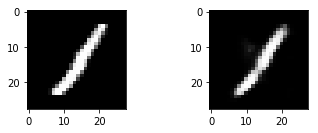

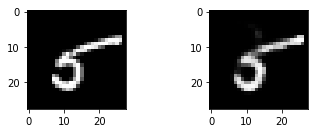

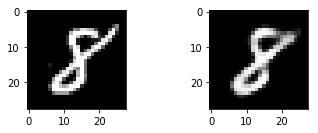

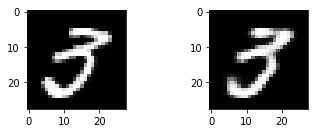

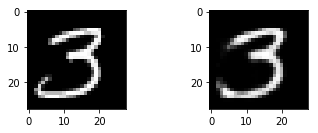

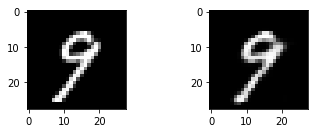

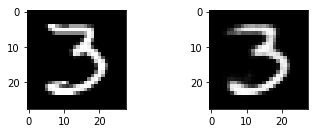

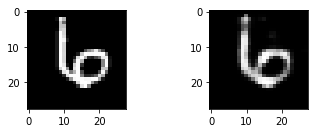

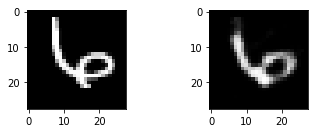

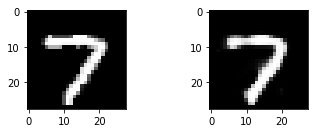

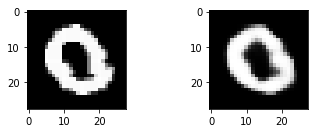

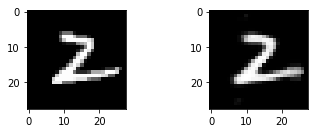

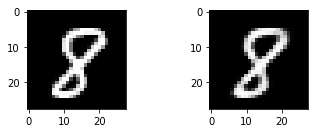

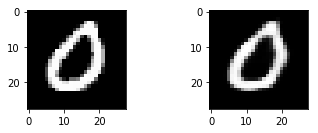

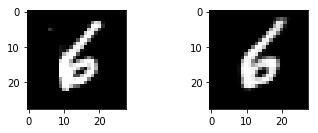

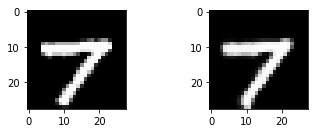

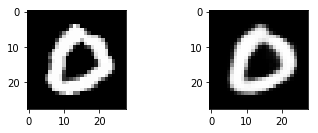

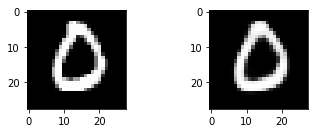

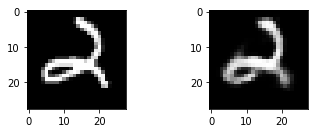

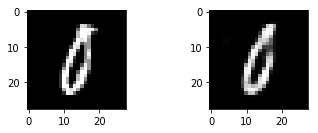

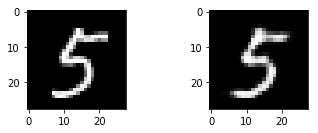

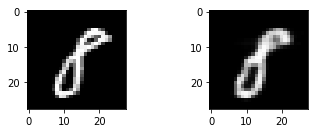

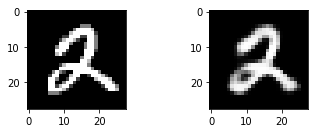

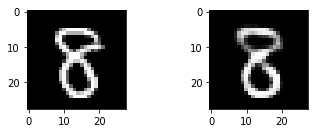

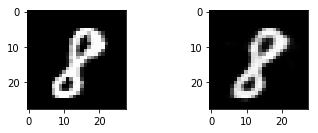

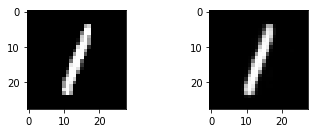

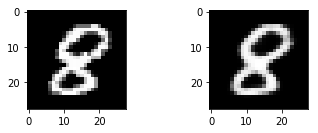

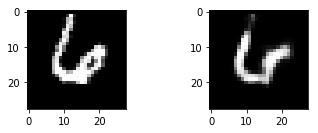

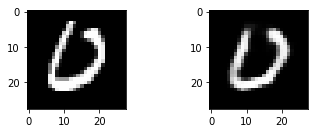

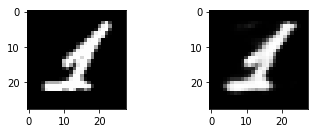

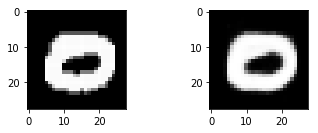

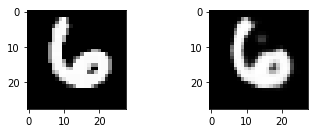

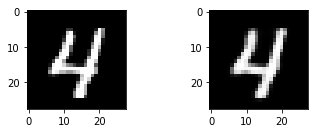

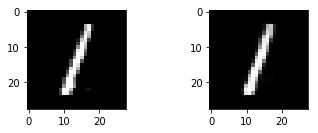

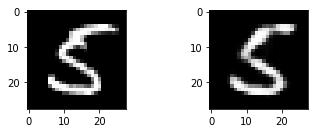

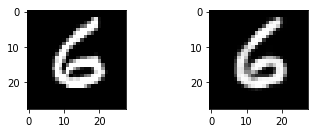

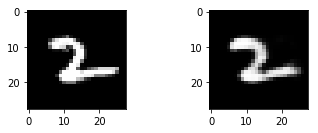

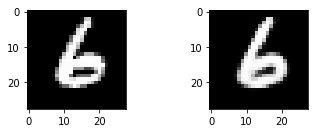

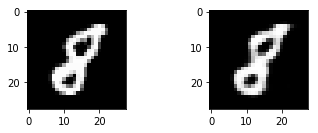

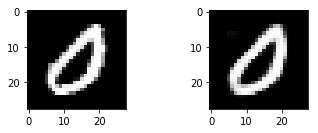

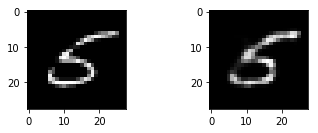

In [10]:
ourModel =Model(Decoder(), Encoder()).to_cpu()

serializers.load_npz('group14_FinalModel_50epochs.model.zip'.format(model_directory),ourModel)


for k, batch1 in enumerate(test_iterator):
    with chainer.using_config('test', False):
        x1 = dataset.concat_examples(batch1)
        mean_z1, ln_var_z1, mean_x1, ln_var_x1 = ourModel(x1)
        x1_res=np.reshape(x1,[-1,28,28])
        rmean_x1=mean_x1.array
        r_mean_x1 = np.reshape(rmean_x1,[-1,28,28])
        plt.figure(k)
        plt.subplot(2,2,1)
        plt.imshow(x1_res[1][:,:], cmap='gray')
        plt.subplot(2,2,2)
        plt.imshow(r_mean_x1[1][:,:], cmap='gray')


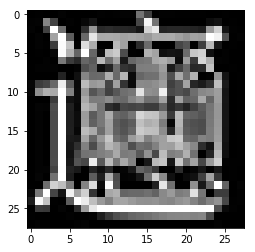

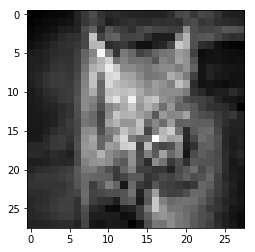

In [10]:
from PIL import Image
import matplotlib.pyplot as pyplot
import numpy as np
from chainer import iterators, dataset
import PIL.ImageOps

model_directory = 'C:\\Users\\Αngeliki-Ilektra\\NeuralInformationProcessingSystems\\3rdAs\\modelDirectory'
batch_size=64
infile1 = 'C:\\Users\\Αngeliki-Ilektra\\NeuralInformationProcessingSystems\\3rdAs\\image1.jpg'
infile2 = 'C:\\Users\\Αngeliki-Ilektra\\NeuralInformationProcessingSystems\\3rdAs\\image2.jpg'

img1 = Image.open(infile1)
img1 = PIL.ImageOps.invert(img1)
Img1 = img1.convert('L')
resize_img1=Img1.resize((28,28),Image.ANTIALIAS)
photo1=np.array(resize_img1)/255
plt.figure(1)
plt.imshow(photo1,cmap='gray')

img2 = Image.open(infile2)
Img2 = img2.convert('L')
resize_img2=Img2.resize((28,28),Image.ANTIALIAS)
photo2=np.array(resize_img2)/255
plt.figure(2)
plt.imshow(photo2,cmap='gray')


resize_photo1=F.reshape(np.array(photo1),(784,))
resize_photo2=F.reshape(np.array(photo2),(784,))
data1=resize_photo1.data
data2=resize_photo2.data
data1 = np.float32(data1)
data2 = np.float32(data2)
ourData1=[data1,data2]
ourData2=[data2,data1]

ourModel =Model(Decoder(), Encoder()).to_cpu()

serializers.load_npz('group14_FinalModel_50epochs.model.zip'.format(model_directory),ourModel)
test_iterator_plus1 = iterators.SerialIterator(ourData1 , batch_size, False, False)
test_iterator_plus2 = iterators.SerialIterator(ourData2 , batch_size, False, False)



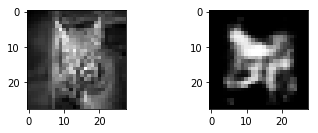

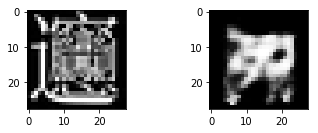

In [11]:
for i,batch in enumerate(test_iterator_plus1):
    with chainer.using_config('test', False):
        x1 =dataset.concat_examples(batch)
        mean_z1, ln_var_z1, mean_x1, ln_var_x1 = ourModel(x1)
        x1_res=np.reshape(x1,[-1,28,28])
        
        #rmean_x1 = np.array(mean_x1)
        rmean_x1=mean_x1.array
        #print(type(rmean_x1))
        r_mean_x1 = np.reshape(rmean_x1,[-1,28,28])
        #print(r_mean_x1.shape)
        
        plt.figure()
        plt.subplot(2,2,1)
        plt.imshow(x1_res[1][:,:],cmap='gray' )
        plt.subplot(2,2,2)
        plt.imshow(r_mean_x1[1][:,:],cmap='gray' )
#print(np.array(Img)/255)"""

for i,batch in enumerate(test_iterator_plus2):
    with chainer.using_config('test', False):
        x1 =dataset.concat_examples(batch)
        mean_z1, ln_var_z1, mean_x1, ln_var_x1 = ourModel(x1)
        x1_res=np.reshape(x1,[-1,28,28])
        
        #rmean_x1 = np.array(mean_x1)
        rmean_x1=mean_x1.array
        #print(type(rmean_x1))
        r_mean_x1 = np.reshape(rmean_x1,[-1,28,28])
        #print(r_mean_x1.shape)
        
        plt.figure()
        plt.subplot(2,2,1)
        plt.imshow(x1_res[1][:,:],cmap='gray' )
        plt.subplot(2,2,2)
        plt.imshow(r_mean_x1[1][:,:],cmap='gray' )
#print(np.array(Img)/255)"""

Bonus task: Try the same experiments on a different dataset. (20 bonus points)

BONUS TASK - Fashion MNIST Dataset
--------------------------------------------------------

In [10]:
#chainer.datasets.get_fashion_mnist(withlabel=True, ndim=1, scale=1.0, dtype=None, label_dtype=<class 'numpy.int32'>, rgb_format=False)
class fashionMnist(DatasetMixin):
    def __init__(self):
        self.dataset = chainer.datasets.get_fashion_mnist(False)[0 if chainer.config.train else 1]

    def __len__(self):
        return len(self.dataset)

    def get_example(self, i):
        return self.dataset[i]
    

 We chose to use the Fashion MNIST Dataset as it had many common properties with the MNIST dataset.
 However, the Fashion MNIST Dataset has more complicated images (every cloth has different details, different shapes etc) and 
 the linear network cannot adjust that well.

INITIALIZATION
-----------------------------------

In [11]:
from chainer import iterators, dataset
Dataset_f = fashionMnist()
device = 0
loss_fn_f = Loss()
batch_size = 64
#model_directory = 'Model'
model_directory_f = 'C:\\Users\\Αngeliki-Ilektra\\NeuralInformationProcessingSystems\\3rdAs\\modelDirectory_f'
model_f = Model(Decoder(), Encoder()).to_cpu()
training_set_f = Dataset_f[:int(0.8*55000)]
validation_set_f = Dataset_f[int(0.8*55000):55000]
test_set_f = Dataset_f[55000:len(Dataset_f)]

loss_history_f = {'training_f': [], 'validation_f': []}


training_iterator_f = iterators.SerialIterator(training_set_f, batch_size, False, True)
validation_iterator_f = iterators.SerialIterator(validation_set_f, batch_size, False, False)
test_iterator_f = iterators.SerialIterator(test_set_f, batch_size, False, False)

#vae.model.to_cpu()
epochs=2
optimizer = chainer.optimizers.Adam()
optimizer.setup(model_f)

TRAINING
-----------------------------------------

In [ ]:
epochs = 100
for i in range(epochs):
    loss_history_f['training_f'].append(0)
    training_iterator_f.reset()
    validation_iterator_f.reset()
    for j, batch in enumerate(training_iterator_f):
        with chainer.using_config('train', True):
            x = dataset.concat_examples(batch1, device)
            
            mean_z, ln_var_z, mean_x, ln_var_x = model_f(x)
            
            # (1) start
            loss_f = loss_fn(mean_z, ln_var_z, x, mean_x, ln_var_x)
            model_f.cleargrads()
            loss_f.backward()

            optimizer.update()
        
        loss_history_f['training_f'][-1] += float(loss_f.data)
    loss_history_f['training_f'][-1] /= j + 1
    
    loss_history_f['validation_f'].append(0)


    for j1, batch1 in enumerate(validation_iterator_f):
        with chainer.using_config('train', False):
            x = dataset.concat_examples(batch1, device)
            mean_z1, ln_var_z1, mean_x1, ln_var_x1 = model_f(x1)

            loss_f = loss_fn(mean_z1, ln_var_z1,x1, mean_x1, ln_var_x1)
            model_f.cleargrads()
            loss_f.backward()

            optimizer.update()
        loss_history_f['validation_f'][-1] += float(loss_f.data)
    loss_history_f['validation_f'][-1] /= j1 + 1

    print("iteration i = ")
    print(i)
    print("is ended and we are going to the next one")
    print("-------------------------------------------")    
    print('epoch: {:3d} / {:03d}, training loss: {:.4f} , validation loss: {:.4f}.'.format(i + 1, epochs, loss_history_f ['training_f'][i], loss_history_f['validation_f'][i]))
    np.savez('{:s}/loss_history_{:03d}.npz'.format(model_directory, epochs), loss_history_f)
    serializers.save_npz('groupVfashion.model', model_f)
    serializers.save_npz('{:s}/optimizer_{:03d}.npz'.format(model_directory, epochs), optimizer)


iteration i = 
0
is ended and we are going to the next one
-------------------------------------------
epoch:   1 / 100, training loss: 41736.5394 , validation loss: 41410.4985.
iteration i = 
1
is ended and we are going to the next one
-------------------------------------------
epoch:   2 / 100, training loss: 40734.3082 , validation loss: 41063.4988.
iteration i = 
2
is ended and we are going to the next one
-------------------------------------------
epoch:   3 / 100, training loss: 40578.0693 , validation loss: 40819.9105.
iteration i = 
3
is ended and we are going to the next one
-------------------------------------------
epoch:   4 / 100, training loss: 40483.7437 , validation loss: 40783.4938.
iteration i = 
4
is ended and we are going to the next one
-------------------------------------------
epoch:   5 / 100, training loss: 40467.8258 , validation loss: 40608.8432.
iteration i = 
5
is ended and we are going to the next one
-------------------------------------------
epoch: 

-------------------------------------------
epoch:  92 / 100, training loss: 40389.9638 , validation loss: 40429.7225.
iteration i = 
92
is ended and we are going to the next one
-------------------------------------------
epoch:  93 / 100, training loss: 40356.9778 , validation loss: 40368.5182.
iteration i = 
93
is ended and we are going to the next one
-------------------------------------------
epoch:  94 / 100, training loss: 40385.8913 , validation loss: 40422.3214.
iteration i = 
94
is ended and we are going to the next one
-------------------------------------------
epoch:  95 / 100, training loss: 40374.2467 , validation loss: 40428.7671.
iteration i = 
95
is ended and we are going to the next one
-------------------------------------------
epoch:  96 / 100, training loss: 40375.5210 , validation loss: 40388.5428.
iteration i = 
96
is ended and we are going to the next one
-------------------------------------------
epoch:  97 / 100, training loss: 40354.9940 , validation loss

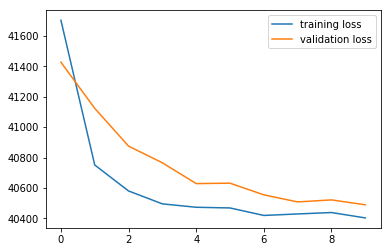

In [43]:
train = plt.plot(np.arange(epochs), loss_history_f['training_f'], label = 'training loss')
validate = plt.plot( np.arange(epochs), loss_history_f['validation_f'], label = 'validation loss')
plt.legend(['training loss', 'validation loss'])

TESTING
-------------------

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


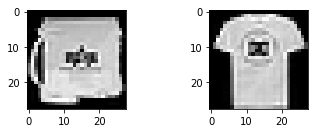

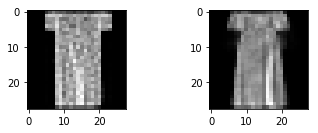

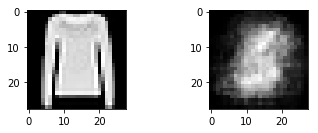

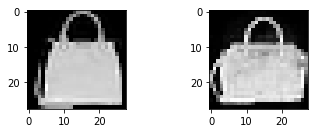

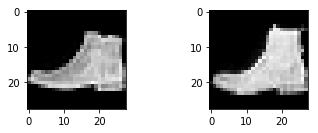

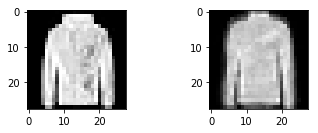

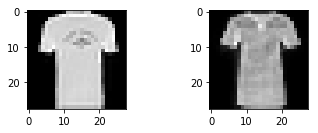

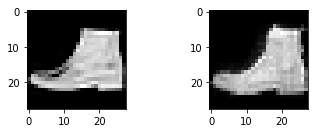

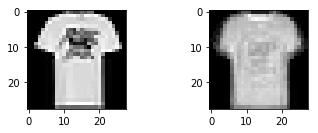

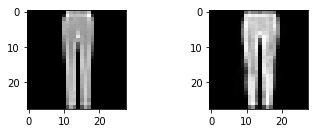

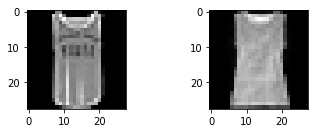

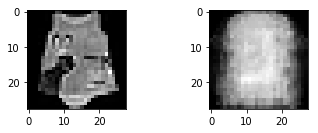

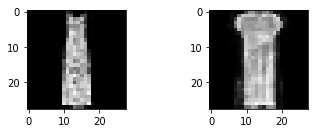

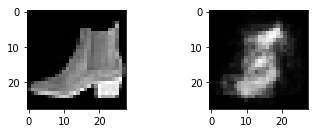

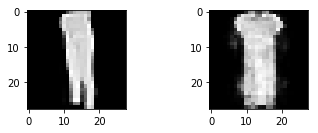

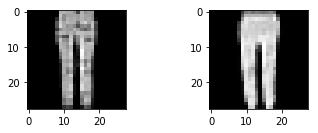

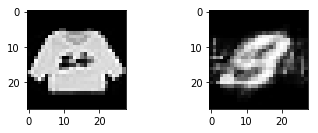

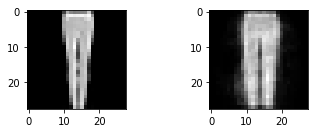

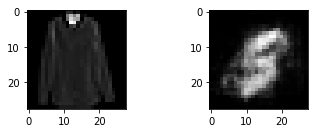

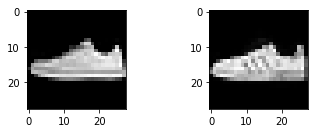

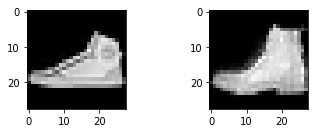

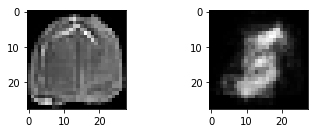

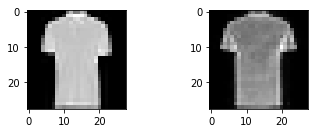

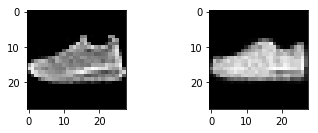

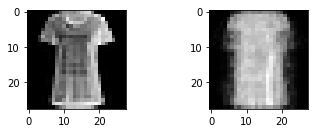

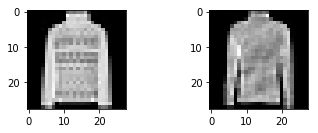

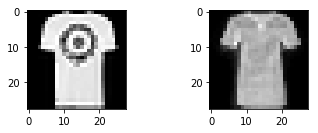

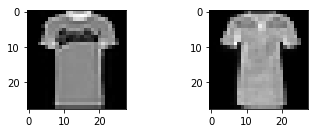

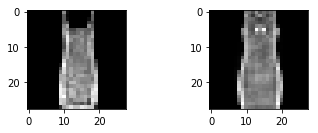

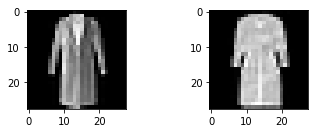

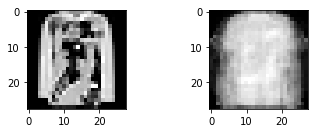

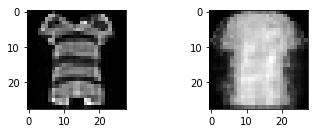

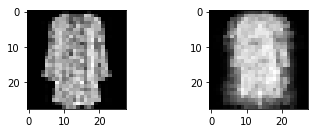

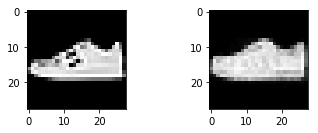

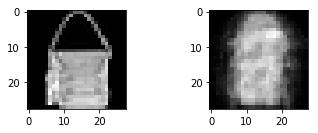

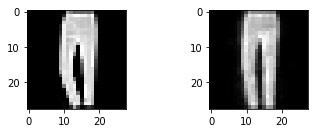

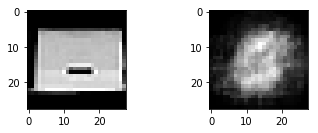

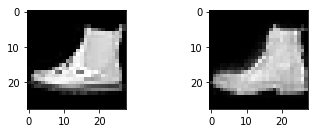

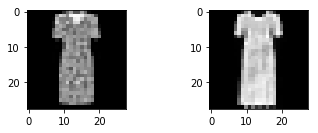

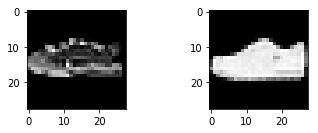

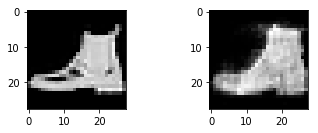

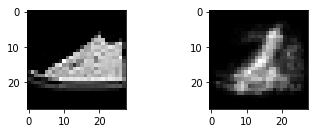

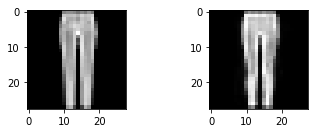

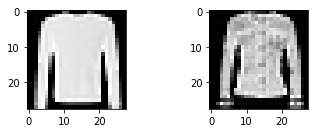

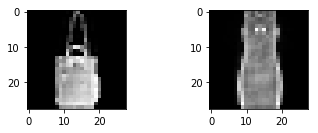

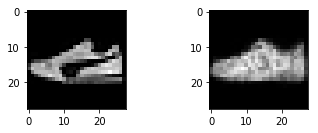

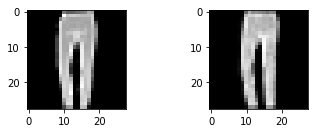

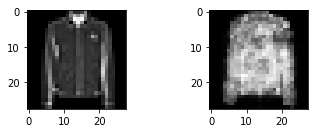

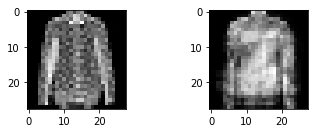

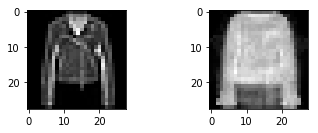

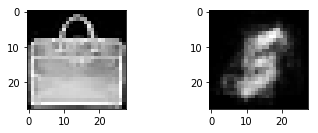

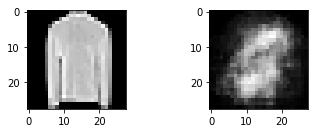

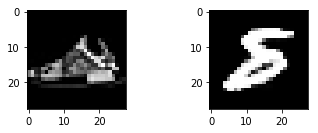

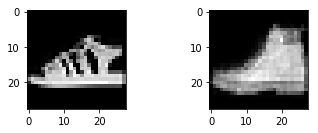

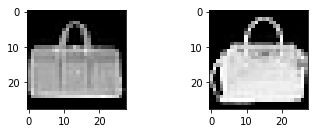

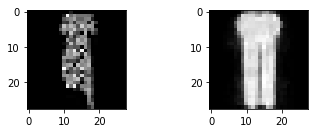

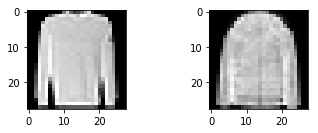

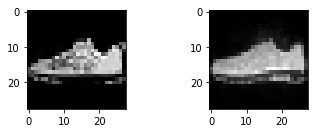

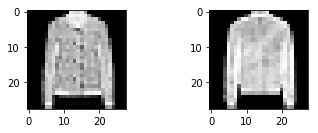

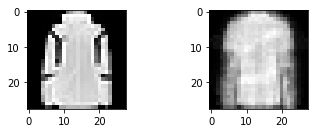

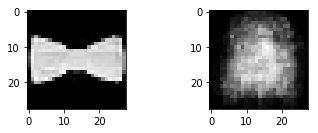

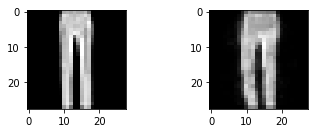

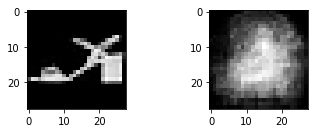

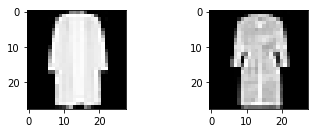

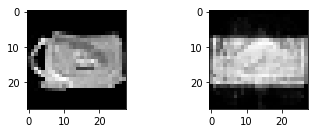

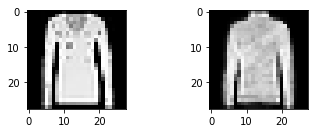

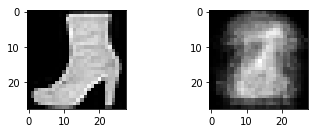

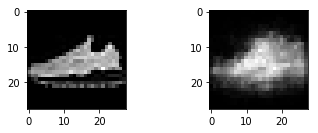

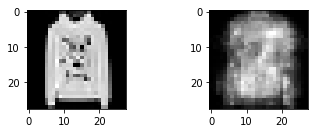

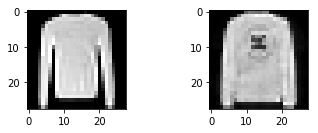

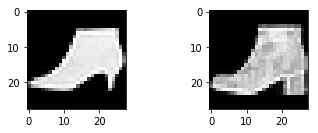

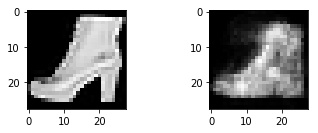

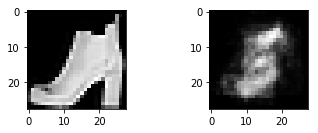

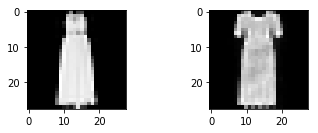

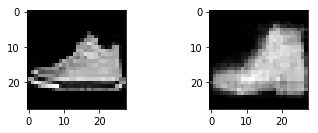

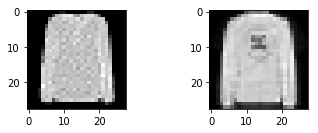

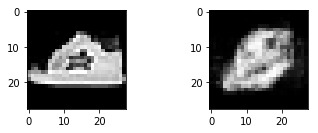

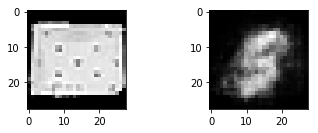

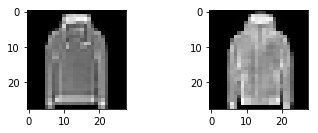

In [12]:
ourModel_f =Model(Decoder(), Encoder()).to_cpu()

serializers.load_npz('groupVfashion.model.zip'.format(model_directory_f),ourModel_f)


for k, batch1 in enumerate(test_iterator_f):
    with chainer.using_config('test', False):
        x1 = dataset.concat_examples(batch1)
        mean_z1, ln_var_z1, mean_x1, ln_var_x1 = ourModel_f(x1)
        x1_res=np.reshape(x1,[-1,28,28])
        rmean_x1=mean_x1.array
        r_mean_x1 = np.reshape(rmean_x1,[-1,28,28])
        
        plt.figure(k)
        plt.subplot(2,2,1)
        plt.imshow(x1_res[1][:,:], cmap='gray')
        plt.subplot(2,2,2)
        plt.imshow(r_mean_x1[1][:,:], cmap='gray')

